# Проект

Требуется написать модуль для сервиса разграничения доступа к информации для пользователей. Ваш модуль должен уметь принимать на вход фотографию пользователя и возвращать его логин в системе. Требования к модулю:

- модуль должен уметь определять, лицо какого пользователя пришло ему во входном изображении;
- модуль должен определять случаи, когда пришло лицо не зарегистрированного человека;
- если на фотографии несколько лиц, то распознавание лица не должно произойти;
- от каждого пользователя системы можно получить только одну фотографию-образец его лица;
- фотографии пользователей хранить запрещено.

Архитектура модуля будет следующей. Структура файлов:

    recognition
    |- model.py
    |- api.py
    |- user_mapping.py

Таким образом, наш модуль будет разделен на 3 части. Теперь опишем подробнее, что должно быть реализовано внутри каждого из этих файлов.

# 1. model.py

Начнем с файла, в котором описана обертка над моделью. Назовем класс-обертку `Model`.

Задачу распознавания лиц можно разделить на две задачи:
1. Детектирование лица, т.е. нахождение на изображении той области, на которой расположено лицо
2. Распознавание (классификация) лица на той области, которую мы получили из п. 1.

Обе эти задачи будем решать в рамках класса `Model`. Опишем протокол этого класса. Пример использования детектора и классификатора лиц будет ниже.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install mtcnn

In [ ]:
import numpy as np
from typing import Optional, Union
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot
from PIL import Image
from scipy.spatial.distance import cosine
import csv

from keras.models import Sequential
from keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation, Dense
from keras import models


class VGGFace(Sequential):
    def __init__(self):
        super(VGGFace, self).__init__()  # наследуемся от базовой модели кераса, поэтому должны
                                         # выполнить всё, что заложено в ее инстанцирование из коробки
        self.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))  # а теперь описываем архитектуру VGGFace
        self.add(Convolution2D(64, (3, 3), activation='relu'))
        self.add(ZeroPadding2D((1,1)))
        self.add(Convolution2D(64, (3, 3), activation='relu'))
        self.add(MaxPooling2D((2,2), strides=(2,2)))
        
        self.add(ZeroPadding2D((1,1)))
        self.add(Convolution2D(128, (3, 3), activation='relu'))
        self.add(ZeroPadding2D((1,1)))
        self.add(Convolution2D(128, (3, 3), activation='relu'))
        self.add(MaxPooling2D((2,2), strides=(2,2)))
        
        self.add(ZeroPadding2D((1,1)))
        self.add(Convolution2D(256, (3, 3), activation='relu'))
        self.add(ZeroPadding2D((1,1)))
        self.add(Convolution2D(256, (3, 3), activation='relu'))
        self.add(ZeroPadding2D((1,1)))
        self.add(Convolution2D(256, (3, 3), activation='relu'))
        self.add(MaxPooling2D((2,2), strides=(2,2)))
        
        self.add(ZeroPadding2D((1,1)))
        self.add(Convolution2D(512, (3, 3), activation='relu'))
        self.add(ZeroPadding2D((1,1)))
        self.add(Convolution2D(512, (3, 3), activation='relu'))
        self.add(ZeroPadding2D((1,1)))
        self.add(Convolution2D(512, (3, 3), activation='relu'))
        self.add(MaxPooling2D((2,2), strides=(2,2)))
        
        self.add(ZeroPadding2D((1,1)))
        self.add(Convolution2D(512, (3, 3), activation='relu'))
        self.add(ZeroPadding2D((1,1)))
        self.add(Convolution2D(512, (3, 3), activation='relu'))
        self.add(ZeroPadding2D((1,1)))
        self.add(Convolution2D(512, (3, 3), activation='relu'))
        self.add(MaxPooling2D((2,2), strides=(2,2)))
        
        self.add(Convolution2D(4096, (7, 7), activation='relu'))
        self.add(Dropout(0.5))
        self.add(Convolution2D(4096, (1, 1), activation='relu'))
        self.add(Dropout(0.5))
        self.add(Convolution2D(2622, (1, 1)))
        self.add(Flatten())
        self.add(Activation('softmax'))


class Model:
    image_size = (224, 224)

    def __init__(self):
        self.model_ready = False  # опишем флаг, который будет говорить нам о том, обучена ли модель.
                                  # если модель не обучена, мы не можем делать предсказания
        self.model = VGGFace()
        self.model.load_weights('/content/drive/MyDrive/Colab Notebooks/my_ds_piscine/t01/vgg_face_weights.h5')
        self.descriptor = models.Model(inputs=self.model.layers[0].input, outputs=self.model.layers[-2].output) # модель без последнего слоя
        self.model_ready = True
        self.porog = 0.5
      

    @classmethod
    def detect_face(cls, image: Union[str, np.array]) -> np.array:
        """Функция, которая принимает строку с путём к файлу изображения
        или массив чисел - изображение (результат pyplot.imread).
        Возвращается массив чисел - новое изображение, где обрезано всё,
        кроме лица (результат работы детектора)"""
        # ваш код детектирования лица

        if type(image) is str:
          img = pyplot.imread(image)
        elif (type(image) is np.array) or (type(image) is np.ndarray):
          img = image
        else:
          print('Detection does not support any type of data except str and np.array')
          return None

        detector = MTCNN()
        faces = detector.detect_faces(img)
        if len(faces) == 1:
          x1, y1, width, height = faces[0]['box']
          x2, y2 = x1 + width, y1 + height
          face = img[y1:y2, x1:x2]
          return face
        else:
          print('There are more than 1 person in the image')
          return None


    def get_face_embedding(self, image: Union[str, np.array]) -> np.array:
        """Метод, который возвращает эмбеддинг входного изображение. Входное изображение может подаваться
        как адрес файла в файловой системе либо как массив чисел, т.е. само изображение"""
        # ваш код получения эмбеддинга

        if not self.model_ready:
            raise RuntimeError("Модель еще не обучена")
        face = self.detect_face(image)
        if face is None:
          return None
        face = np.asarray(Image.fromarray(face).resize((224, 224))).reshape(-1, 224, 224, 3)
        face_embedding = self.descriptor.predict(face)[0,:]
        return face_embedding


    def compare(self, image1: Union[str, np.array], image2: Union[str, np.array]) -> int:
        """Функция, которая принимает два массива чисел - изображений, и возвращает номер класса объекта, 
        предсказанный моделью. Если модель еще не обучена, нужно вызвать исключение"""
        if not self.model_ready:
            raise RuntimeError("Модель еще не обучена")
        # ваш код предсказания класса объекта

        embedding1 = self.get_face_embedding(image1)
        if embedding1 is None:
          return None
        embedding2 = self.get_face_embedding(image2)
        if embedding2 is None:
          return None
        return cosine(embedding1, embedding2)


    def recognize_from_db(self, image: Union[str, np.array], db: "DataBase") -> Optional[str]:
        """Функция, которая принимает адрес изображения или само изображение в виде массива numpy,
        а также объект класса DataBase, описанный в соседнем файле, и возвращает логин пользователя,
        которому принадлежит лицо, либо None, если похожего человека нет в базе"""
        # ваш код поиска нужного человека в базе данных

        face1_embedding = self.get_face_embedding(image)
        if face1_embedding is None:
          return None

        face2_array = db.get_all()

        for face2_embedding in face2_array:
          distance = cosine(face1_embedding, face2_embedding)
          if distance <= self.porog:
            login = db.get_login(face2_embedding)
            print(f'Person was found: {login}')
            return login
        print('Nobody was found')
        return None


## 2. database.py

В этом файле мы опишем класс `DataBase`, в который поместим логику работы с хранением сущностей зарегистрированных в нашей системе профилей. Фотографии пользователей хранить нельзя. Поэтому создадим базу данных, в которой будут храниться эмбеддинги, логины пользователей и дата регистрации. В качестве БД предлагается использовать csv-файл или SQLite, если вы с ней уже сталкивались.

In [ ]:
import numpy as np
import pandas as pd
import csv


class DataBase:
    BASE_DIR = '/content/drive/MyDrive/Colab Notebooks/my_ds_piscine/t01/data_base.csv'
    LENGTH = 0

    def __init__(self):
      DataBase.LENGTH = DataBase.get_start_len()

    @classmethod
    def get_start_len(cls):
      df = pd.read_csv(cls.BASE_DIR, names=['login', 'embedding'])
      return len(df)

    @staticmethod
    def str_arr(str_embedding):
        embedding = str_embedding.split(' ')
        embedding = [float(item) for item in embedding]
        return np.array(embedding)


    @staticmethod
    def arr_str(embedding):
        str_embedding = embedding.tolist()
        str_embedding = [str(item) for item in embedding]
        return ' '.join(str_embedding)


    def add_new_face(self, login: str, embedding: np.array):
        """Метод, который добавляет новое лицо в базу данных. Принимает на вход аргумент
        login - это строка-логин пользователя, а также аргумент embedding - это вектор
        чисел-эмбеддинг лица человека, который нужно сохранить в базу"""
        # ваш код здесь

        str_embedding = self.arr_str(embedding)

        df = pd.read_csv(self.BASE_DIR, names=['login', 'embedding'])
        if len(df[df['login'] == login]) != 0 or len(df[df['embedding'] == str_embedding]):
          print(f'This profile exists: {login}')
          return None
        
        with open(self.BASE_DIR, 'a', newline='') as f_object:
          writer_object = csv.writer(f_object)
          writer_object.writerow([login, str_embedding])  
          f_object.close()
          DataBase.LENGTH += 1


    def update_face(self, login: str, embedding: np.array):
        """Метод, который обновляет лицо пользователя в базе. Аргументы - те же, что в add_new_face.
        В поле с датой добавления пользователя должна попасть дата обновления."""
        # ваш код здесь

        str_embedding = self.arr_str(embedding)

        df = pd.read_csv(self.BASE_DIR, names=['login', 'embedding'])
        if len(df[df['login'] == login]) == 0:
          print('You should register user and then update photo')
          return None
        df.loc[df['login'] == login, 'embedding'] = str_embedding
        df.to_csv(self.BASE_DIR, header=None)


    def delete_user(self, login):
        """Метод, который удаляет логин пользователя из базы данных. Обсудите с коллегами,
        стоит ли после удаления пользователя оставлять его фотографию в папке или нет"""
        # ваш код здесь

        df = pd.read_csv(self.BASE_DIR, names=['login', 'embedding'])
        index_to_del = df[df['login'] == login].index
        df.drop(index_to_del, inplace=True)
        df.to_csv(self.BASE_DIR, header=None)
        DataBase.LENGTH -= 1


    def get(self, login: str) -> np.array:
        """Метод, который возвращает массив чисел - эмбеддинг, соответствующий логину пользователя"""
        # ваш код здесь

        df = pd.read_csv(self.BASE_DIR, names=['login', 'embedding'])
        str_embedding = df.loc[df['login'] == login].iloc[0, 1]
        return self.str_arr(str_embedding)


    def get_login(self, embedding: np.array) -> str:
        """Метод, который возвращает массив чисел - эмбеддинг, соответствующий логину пользователя <>"""
        # ваш код здесь

        str_embedding = self.arr_str(embedding)

        df = pd.read_csv(self.BASE_DIR, names=['login', 'embedding'])
        login = df[df['embedding'] == str_embedding].iloc[0, 0]
        return login


    def get_all(self):
        """Этот метод должен возвращать все эмбеддинги для того, чтобы объект класса Model
        мог их сравнить с поступившим лицом. Продумайте, что он должен возвращать, исходя из 
        того, чтобы использование оперативной памяти было минимальным (ведь в нашей БД могут быть
        тысячи пользователей)"""
        # ваш код здесь

        df = pd.read_csv(self.BASE_DIR, names=['login', 'embedding'])
        embeddings = [self.str_arr(e) for e in df['embedding']]
        return np.array(embeddings)


    def count(self) -> int:
        """Этот метод возвращает количество зарегистрированных в базе пльзователей"""
        # ваш код

        return DataBase.LENGTH


    def clear(self):
        """Обнуление базы данных. Этот метод должен удалить все данные, но не сам файл базы"""
        # ваш код

        df = pd.DataFrame({'login' : [], 'embedding' : []})
        df.to_csv(self.BASE_DIR, header=None)
        DataBase.LENGTH = 0


In [ ]:
!touch /content/drive/MyDrive/Colab\ Notebooks/my_ds_piscine/t01/data_base.csv

In [ ]:
db = DataBase()

In [ ]:
db.clear()

In [ ]:
db.count()

0

In [ ]:
mod = Model()

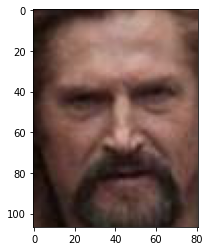

In [ ]:
dzh = mod.detect_face('/content/drive/MyDrive/Colab Notebooks/my_ds_piscine/t01/data-samples/dzhigurda.jpg')
pyplot.imshow(dzh)
pyplot.show()

In [ ]:
mod.get_face_embedding('/content/drive/MyDrive/Colab Notebooks/my_ds_piscine/t01/data-samples/dzhigurda.jpg')

array([ 7.6035204, -2.5394523, -4.449444 , ..., -1.5119591, -4.236768 ,
       -1.3641628], dtype=float32)

In [ ]:
db.add_new_face('dzhig', mod.get_face_embedding('/content/drive/MyDrive/Colab Notebooks/my_ds_piscine/t01/data-samples/dzhigurda.jpg'))

In [ ]:
mod.recognize_from_db('/content/drive/MyDrive/Colab Notebooks/my_ds_piscine/t01/data-samples/dzh.jpg', db)

Person was found: dzhig


'dzhig'

In [ ]:
db.count()

1

In [ ]:
db2 = DataBase()

In [ ]:
db2.count()

1

In [ ]:
db2.add_new_face('potter', mod.get_face_embedding('/content/drive/MyDrive/Colab Notebooks/my_ds_piscine/t01/data-samples/potter.jpg'))

In [ ]:
db2.count()

2

In [ ]:
db.count()

2

In [ ]:
db.add_new_face('potter', mod.get_face_embedding('/content/drive/MyDrive/Colab Notebooks/my_ds_piscine/t01/data-samples/potter.jpg'))

This profile exists: potter


In [ ]:
mod.recognize_from_db('/content/drive/MyDrive/Colab Notebooks/my_ds_piscine/t01/data-samples/dzh.jpg', db)

Person was found: dzhig


'dzhig'

In [ ]:
db.delete_user('potter')

In [ ]:
db.count()

1

In [ ]:
db2.count()

1

In [ ]:
mod.recognize_from_db('/content/drive/MyDrive/Colab Notebooks/my_ds_piscine/t01/data-samples/dzh.jpg', db)

Person was found: dzhig


'dzhig'

In [ ]:
db.get_login(mod.get_face_embedding('/content/drive/MyDrive/Colab Notebooks/my_ds_piscine/t01/data-samples/dzhigurda.jpg'))

'dzhig'

In [ ]:
db.get('dzhig')

array([ 7.6035204, -2.5394523, -4.449444 , ..., -1.5119591, -4.236768 ,
       -1.3641628])

In [ ]:
db.add_new_face('potter', mod.get_face_embedding('/content/drive/MyDrive/Colab Notebooks/my_ds_piscine/t01/data-samples/potter.jpg'))

In [ ]:
db.count()

2

## 3. api.py

В это файле опишем набор функций, который будет служить точкой входя для всех внешних потребителей нашего модуля. По сути это описание всего, что может сделать пользователь нашей системы в нашей системе. Этот подмодуль будет связующим между всеми компонентами нашей системы, и в нём будет описана та логика, которая будет объединять использование модели и базы данных.

Вам предлагается самостоятельно реализовать функции, которые будут позволять следующее:

- регистрация нового пользователя (логин + фото или URL фото)
- обновление данных о пользователе
- удаление пользователя
- определение пользователя на фотографии
- сравнение людей на двух фотографиях (URL фото или само фото)
- вывод статистики по БД: количество зарегистрированных пользователей
- обнуление базы данных

In [ ]:
# import numpy as np
# from typing import Union
# from model import Model
# from database import DataBase

db = DataBase()
mod = Model()

def register_user(login: str, image: Union[str, np.array]):
    # ваш код

    embedding = mod.get_face_embedding(image)
    if embedding is None:
      return None
    db.add_new_face(login, embedding)


# ваш код остальных функций API


def update_user_photo(login: str, image: Union[str, np.array]):
    embedding = mod.get_face_embedding(image)
    if embedding is None:
      return None
    db.update_face(login, embedding)


def delete_user(login):
    db.delete_user(login)


def recognize_user(image: Union[str, np.array]):
    mod.recognize_from_db(image, db)


def compare_two_people(image1: Union[str, np.array], image2: Union[str, np.array]):
    distance = mod.compare(image1, image2)
    if distance is None:
      return None
    if distance <= mod.porog:
      print('This is the same person')
    else:
      print('There are different people in the images')


def count_register_users():
    print(db.count())
    return db.count()


def reset_db():
    db.clear()

In [ ]:
count_register_users()

2


2

In [ ]:
reset_db()

In [ ]:
count_register_users()

0


0

In [ ]:
register_user('potter', '/content/drive/MyDrive/Colab Notebooks/my_ds_piscine/t01/data-samples/potter.jpg')

In [ ]:
count_register_users()

1


1

In [ ]:
recognize_user('/content/drive/MyDrive/Colab Notebooks/my_ds_piscine/t01/data-samples/dzh.jpg')

Nobody was found


In [ ]:
update_user_photo('potter', '/content/drive/MyDrive/Colab Notebooks/my_ds_piscine/t01/data-samples/dzhigurda.jpg')

In [ ]:
recognize_user('/content/drive/MyDrive/Colab Notebooks/my_ds_piscine/t01/data-samples/dzh.jpg')

Person was found: potter


In [ ]:
update_user_photo('potter', '/content/drive/MyDrive/Colab Notebooks/my_ds_piscine/t01/data-samples/potter.jpg')

In [ ]:
register_user('dzhig', '/content/drive/MyDrive/Colab Notebooks/my_ds_piscine/t01/data-samples/dzhigurda.jpg')

In [ ]:
count_register_users()

2


2

In [ ]:
compare_two_people('/content/drive/MyDrive/Colab Notebooks/my_ds_piscine/t01/data-samples/dzhigurda.jpg', '/content/drive/MyDrive/Colab Notebooks/my_ds_piscine/t01/data-samples/dzh.jpg')

This is the same person


In [ ]:
compare_two_people('/content/drive/MyDrive/Colab Notebooks/my_ds_piscine/t01/data-samples/dzh.jpg', '/content/drive/MyDrive/Colab Notebooks/my_ds_piscine/t01/data-samples/potter.jpg')

There are different people in the images


In [ ]:
reset_db()

In [ ]:
register_user('d', '/content/drive/MyDrive/Colab Notebooks/my_ds_piscine/t01/data-samples/dzhigurda.jpg')

In [ ]:
recognize_user('/content/drive/MyDrive/Colab Notebooks/my_ds_piscine/t01/data-samples/dzh.jpg')

Person was found: d
